In [33]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.ticker import ScalarFormatter, OldScalarFormatter
import matplotlib.ticker as plticker

import psycopg2 as pg
import mysql.connector
from mysql.connector import errorcode
from ittutils import ittconnection, get_resampled, get_raw_price, get_raw_volume, classification_dataset_from_ts

In [45]:
PAST = 100

def check_signal(source, transaction_coin, counter_coin, R_PERIOD, signals_df):
    query = "SELECT * FROM indicator_priceresampl WHERE source=%d AND transaction_currency='%s' AND counter_currency=%d "
    query = query % (source, transaction_coin, counter_coin)
    df_sql = pd.read_sql(query, con=db_connection)
    df_sql['timestamp'] = pd.to_datetime(df_sql['timestamp'], unit='s')
    df_sql.index = pd.DatetimeIndex(df_sql.timestamp)
    
    df_sql.sort_index(ascending=True, inplace=True)
    price_df = df_sql.tail(PAST)
    time_start = price_df.head(1).index[0]
    print(time_start)
    
    price_high_ts = price_df['high_price'] * 10**-8
    price_low_ts = price_df['low_price'] * 10**-8
    closing_price_ts = price_df['close_price'] * 10**-8
    open_price_ts = price_df['open_price'] * 10**-8
    midpoint_price = price_df['midpoint_price'] * 10**-8
    mean_price = price_df['mean_price'] * 10**-8

    # combine everythin into one dataFrame
    df = pd.DataFrame({
        'idx_col': price_low_ts.index,
        'low': price_low_ts,
        'high': price_high_ts, 
        'closing': closing_price_ts,
        'open': open_price_ts,
        'midpoint' : midpoint_price,
        'mean_pr': mean_price
    })
       
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
    fig.suptitle("mean price and signals || source=%d  || %s/%d || period = %d" % (source, transaction_coin, counter_coin, R_PERIOD))
    ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
    
    #fmt = ScalarFormatter(useOffset=False)
    #fmt.set_scientific(False)    
    #ax1.yaxis.set_major_formatter(fmt)
    
    ax1.grid(True)
    #loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    #ax1.xaxis.set_major_locator(loc)
    
    
    #ax1.plot(df.open, color='black', linewidth=2)
    #ax1.plot(df.closing, color='black', linewidth=2)
    ax1.plot(df.mean_pr, color='black', linewidth=2)


    #  signal
#     for time_of_signal in signals_df.index:
#         ax1.axvline(time_of_signal, color='blue')
#         print(time_of_signal)

    for index, row in signals_df[signals_df.index>=time_start].iterrows():
        print(str(index) + ' --- ' + str(row.probability_same))
        ax1.axvline(index, color='blue')
        

    # sell signal
    #for time_of_signal in df[df.conversion_cross_base_down==True].index:
    #    ax1.axvline(time_of_signal, color='red')

    plt.show()



# Overview of all signals

In [35]:
db_connection = ittconnection('stage')
cursor = db_connection.cursor()


In [36]:
query = (" SELECT * FROM signal_signal WHERE signal = 'ANN_AnomalyPrc' and resample_period = 60 ")
signals_df = pd.read_sql(query, con=db_connection)
signals_df = signals_df.tail(PAST)

# make index a timestamp relative_strength
signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='s')
signals_df.index = pd.DatetimeIndex(signals_df.timestamp)
signals_df.sort_index(inplace=True)

#signals_df[['timestamp','id','source','signal','horizon','resample_period']]
signals_df.tail(5)

,id,created_at,modified_at,UI,subscribers_only,text,source,transaction_currency,signal,trend,...,volume_usdt_change,sent_at,timestamp,rsi_value,counter_currency,resample_period,predicted_ahead_for,probability_down,probability_same,probability_up
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-06 08:33:00,1150201,2018-10-06 08:33:16.120981+00:00,2018-10-06 08:33:16.308896+00:00,0,True,,1,BLK,ANN_AnomalyPrc,0,...,None,1.538815e+09,2018-10-06 08:33:00,None,0,60,480,None,0.066643,None
2018-10-06 08:33:00,1150203,2018-10-06 08:33:29.192266+00:00,2018-10-06 08:33:29.376995+00:00,0,True,,1,WAVES,ANN_AnomalyPrc,0,...,None,1.538815e+09,2018-10-06 08:33:00,None,0,60,480,None,0.030086,None
2018-10-06 08:33:00,1150210,2018-10-06 08:34:01.889974+00:00,2018-10-06 08:34:02.105672+00:00,0,True,,2,NAV,ANN_AnomalyPrc,0,...,None,1.538815e+09,2018-10-06 08:33:00,None,1,60,480,None,0.064956,None
2018-10-06 08:34:00,1150216,2018-10-06 08:34:17.582838+00:00,2018-10-06 08:34:17.814679+00:00,0,True,,2,ETC,ANN_AnomalyPrc,0,...,None,1.538815e+09,2018-10-06 08:34:00,None,1,60,480,None,0.047898,None
2018-10-06 08:34:00,1150226,2018-10-06 08:34:45.544826+00:00,2018-10-06 08:34:45.694271+00:00,0,True,,2,BTS,ANN_AnomalyPrc,0,...,None,1.538815e+09,2018-10-06 08:34:00,None,1,60,480,None,0.042037,None


# Draw a particular Signal

In [38]:
source=2
transaction_coin="ETH"
counter_coin=0
R_PERIOD=60

query = (" SELECT * FROM signal_signal WHERE source=%d and signal='ANN_AnomalyPrc' and transaction_currency='%s' and counter_currency=%d and resample_period =%d ")
query = query % (source, transaction_coin, counter_coin, R_PERIOD)
signals_df = pd.read_sql(query, con=db_connection)
signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='s')
signals_df.index = pd.DatetimeIndex(signals_df.timestamp)
signals_df.sort_index(inplace=True)
signals_df.tail(5)


,id,created_at,modified_at,UI,subscribers_only,text,source,transaction_currency,signal,trend,...,volume_usdt_change,sent_at,timestamp,rsi_value,counter_currency,resample_period,predicted_ahead_for,probability_down,probability_same,probability_up
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-05 14:13:00,1144286,2018-10-05 14:14:00.055661+00:00,2018-10-05 14:14:00.317069+00:00,0,True,,2,ETH,ANN_AnomalyPrc,0,...,None,1.538749e+09,2018-10-05 14:13:00,None,0,60,480,None,0.030591,None
2018-10-05 21:23:00,1146334,2018-10-05 21:24:00.419474+00:00,2018-10-05 21:24:00.714173+00:00,0,True,,2,ETH,ANN_AnomalyPrc,0,...,None,1.538775e+09,2018-10-05 21:23:00,None,0,60,480,None,0.069618,None
2018-10-06 01:35:00,1147842,2018-10-06 01:35:28.403439+00:00,2018-10-06 01:35:28.776003+00:00,0,True,,2,ETH,ANN_AnomalyPrc,0,...,None,1.538790e+09,2018-10-06 01:35:00,None,0,60,480,None,0.049557,None
2018-10-06 02:22:00,1148128,2018-10-06 02:22:18.565707+00:00,2018-10-06 02:22:18.749007+00:00,0,True,,2,ETH,ANN_AnomalyPrc,0,...,None,1.538793e+09,2018-10-06 02:22:00,None,0,60,480,None,0.049557,None
2018-10-06 04:01:00,1148615,2018-10-06 04:01:16.195753+00:00,2018-10-06 04:01:16.366853+00:00,0,True,,2,ETH,ANN_AnomalyPrc,0,...,None,1.538798e+09,2018-10-06 04:01:00,None,0,60,480,None,0.033497,None


2018-09-30 15:01:00
2018-10-05 14:13:00 --- 0.0305914174363239
2018-10-05 21:23:00 --- 0.0696184769509821
2018-10-06 01:35:00 --- 0.0495573691705672
2018-10-06 02:22:00 --- 0.0495573691705672
2018-10-06 04:01:00 --- 0.0334971319369618


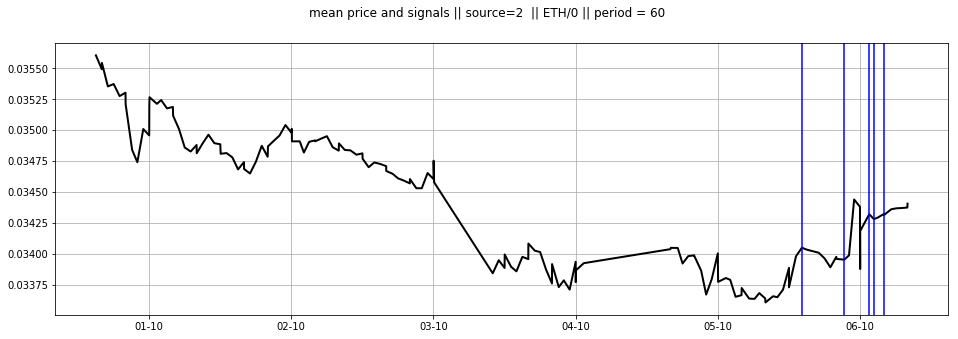

In [39]:

check_signal(source=source, transaction_coin=transaction_coin, counter_coin=counter_coin, R_PERIOD=R_PERIOD, signals_df=signals_df)

2018-09-30 15:01:00
2018-09-30 18:01:00 --- 0.050834274873342
2018-10-03 17:08:00 --- 0.0352377746389984
2018-10-04 22:04:00 --- 0.0305489807290068
2018-10-05 07:01:00 --- 0.0225000449347766
2018-10-05 15:01:00 --- 0.0621912257249896
2018-10-05 17:04:00 --- 0.0458094360533264
2018-10-05 18:03:00 --- 0.0293878829743027
2018-10-06 04:01:00 --- 0.0484302774968428


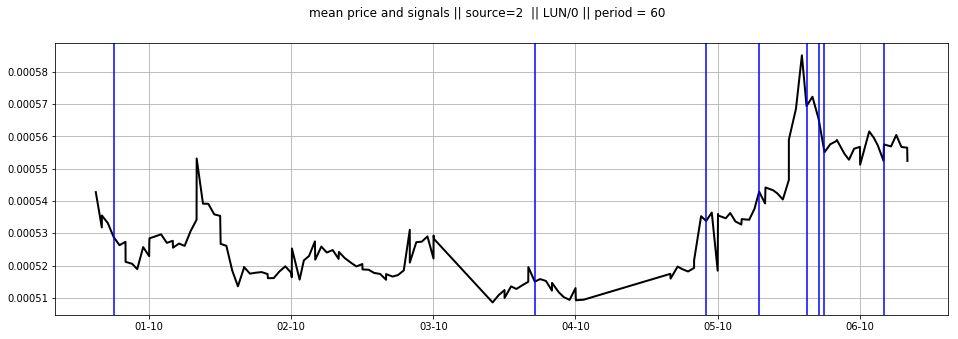

In [40]:
source=2
transaction_coin="LUN"
counter_coin=0
R_PERIOD=60

query = (" SELECT * FROM signal_signal WHERE source=%d and signal='ANN_AnomalyPrc' and transaction_currency='%s' and counter_currency=%d and resample_period =%d ")
query = query % (source, transaction_coin, counter_coin, R_PERIOD)
signals_df = pd.read_sql(query, con=db_connection)
signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='s')
signals_df.index = pd.DatetimeIndex(signals_df.timestamp)
signals_df.sort_index(inplace=True)
signals_df
check_signal(source=source, transaction_coin=transaction_coin, counter_coin=counter_coin, R_PERIOD=R_PERIOD, signals_df=signals_df)

2018-09-30 09:24:00
2018-10-01 02:14:00 --- 0.0326896807106122
2018-10-04 17:42:00 --- 0.0482664917377568
2018-10-04 18:21:00 --- 0.0584643773177801


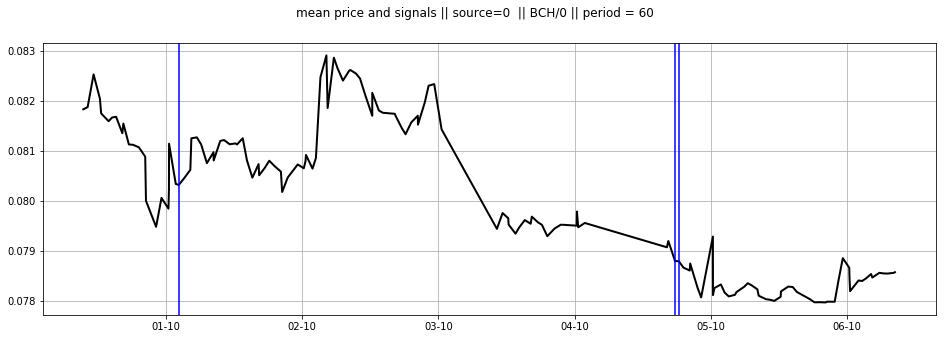

In [41]:
source=0
transaction_coin="BCH"
counter_coin=0
R_PERIOD=60

query = (" SELECT * FROM signal_signal WHERE source=%d and signal='ANN_AnomalyPrc' and transaction_currency='%s' and counter_currency=%d and resample_period =%d ")
query = query % (source, transaction_coin, counter_coin, R_PERIOD)
signals_df = pd.read_sql(query, con=db_connection)
signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='s')
signals_df.index = pd.DatetimeIndex(signals_df.timestamp)
signals_df.sort_index(inplace=True)
signals_df
check_signal(source=source, transaction_coin=transaction_coin, counter_coin=counter_coin, R_PERIOD=R_PERIOD, signals_df=signals_df)

2018-09-30 09:22:00
2018-10-04 21:38:00 --- 0.061449521242518
2018-10-04 22:16:00 --- 0.0626995251132366
2018-10-05 05:53:00 --- 0.0380261454511892
2018-10-05 08:25:00 --- 0.044723462609778
2018-10-05 10:19:00 --- 0.0445941730810411


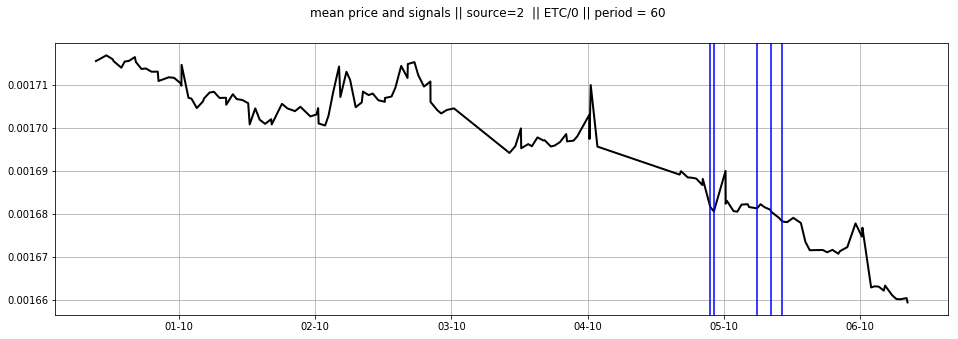

In [42]:
source=2
transaction_coin="ETC"
counter_coin=0
R_PERIOD=60

query = (" SELECT * FROM signal_signal WHERE source=%d and signal='ANN_AnomalyPrc' and transaction_currency='%s' and counter_currency=%d and resample_period =%d ")
query = query % (source, transaction_coin, counter_coin, R_PERIOD)
signals_df = pd.read_sql(query, con=db_connection)
signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='s')
signals_df.index = pd.DatetimeIndex(signals_df.timestamp)
signals_df.sort_index(inplace=True)
signals_df
check_signal(source=source, transaction_coin=transaction_coin, counter_coin=counter_coin, R_PERIOD=R_PERIOD, signals_df=signals_df)

2018-09-30 11:08:00


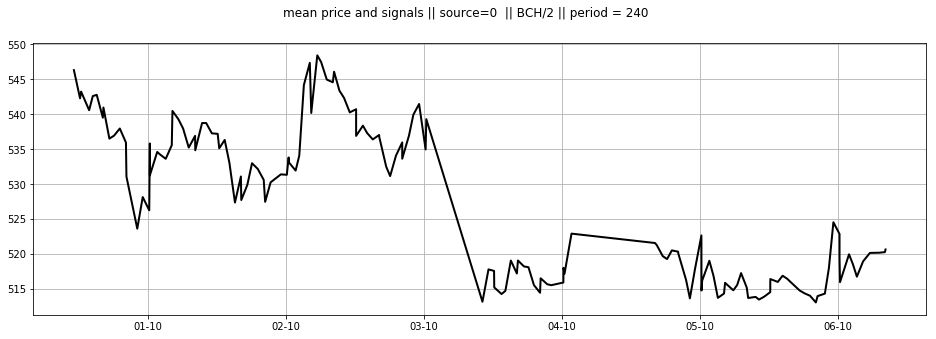

In [43]:
source=0
transaction_coin="BCH"
counter_coin=2
R_PERIOD=240

query = (" SELECT * FROM signal_signal WHERE source=%d and signal='ANN_AnomalyPrc' and transaction_currency='%s' and counter_currency=%d and resample_period =%d ")
query = query % (source, transaction_coin, counter_coin, R_PERIOD)
signals_df = pd.read_sql(query, con=db_connection)
signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='s')
signals_df.index = pd.DatetimeIndex(signals_df.timestamp)
signals_df.sort_index(inplace=True)
signals_df
check_signal(source=source, transaction_coin=transaction_coin, counter_coin=counter_coin, R_PERIOD=R_PERIOD, signals_df=signals_df)

2018-09-30 09:22:00
2018-10-06 08:14:00 --- 0.0331869246266254


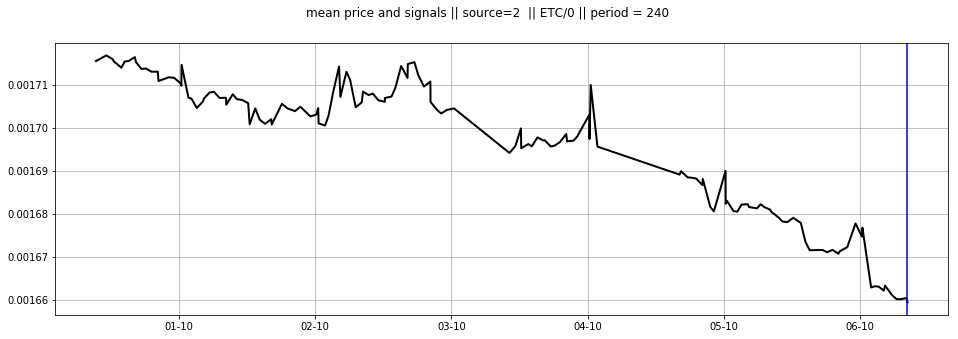

In [44]:
source=2
transaction_coin="ETC"
counter_coin=0
R_PERIOD=240

query = (" SELECT * FROM signal_signal WHERE source=%d and signal='ANN_AnomalyPrc' and transaction_currency='%s' and counter_currency=%d and resample_period =%d ")
query = query % (source, transaction_coin, counter_coin, R_PERIOD)
signals_df = pd.read_sql(query, con=db_connection)
signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='s')
signals_df.index = pd.DatetimeIndex(signals_df.timestamp)
signals_df.sort_index(inplace=True)
signals_df
check_signal(source=source, transaction_coin=transaction_coin, counter_coin=counter_coin, R_PERIOD=R_PERIOD, signals_df=signals_df)